In [1]:
from finlab.data import Data
data = Data()

# 條件一：公司的市值

In [2]:
# 先拿出計算市值需要用到的財務數據

股本 = data.get('股本合計', 1)
price = data.get('收盤價', 100)

In [3]:

# ----------- #
# 找出當天股價  #
# ----------- #

# 新版（較簡單）：將頻率為「天」的股價，reindex 成每「季」
# method='ffill'是說，假如公佈財報那天沒有股價，則以時間往前最接近的那天為主。

當天股價 = price.reindex(股本.index, method='ffill').iloc[-1]

# 原本（較難）：
#當天股價 = price.loc[:股本.index[0]].iloc[-1]

# ----------- #
# 找出當天股本  #
# ----------- #

當天股本 = 股本.iloc[-1]

# -----------  #
# 計算市值      #
# -----------  #

# 市值 = 總股數 * 股價
#     = （股本 * 1000） / 10 * 股價

市值 = 當天股本 * 1000 / 10 * 當天股價
市值['1101']

202235243670.0

# 條件二：自由現金流

In [4]:
import pandas as pd

# 將每季累計的財務數據，轉換成單季
def toSeasonal(df):
    season4 = df[df.index.month == 3]
    season1 = df[df.index.month == 5]
    season2 = df[df.index.month == 8]
    season3 = df[df.index.month == 11]

    season1.index = season1.index.year
    season2.index = season2.index.year
    season3.index = season3.index.year
    season4.index = season4.index.year - 1

    newseason1 = season1
    newseason2 = season2 - season1.reindex_like(season2)
    newseason3 = season3 - season2.reindex_like(season3)
    newseason4 = season4 - season3.reindex_like(season4)

    newseason1.index = pd.to_datetime(newseason1.index.astype(str) + '-05-15')
    newseason2.index = pd.to_datetime(newseason2.index.astype(str) + '-08-14')
    newseason3.index = pd.to_datetime(newseason3.index.astype(str) + '-11-14')
    newseason4.index = pd.to_datetime((newseason4.index + 1).astype(str) + '-03-31')

    return newseason1.append(newseason2).append(newseason3).append(newseason4).sort_index()
    
# 計算自由現金流 = 營業活動之淨現金流入 - 投資活動之淨現金流出
投資現金流 = toSeasonal(data.get('投資活動之淨現金流入（流出）', 8))
營業現金流 = toSeasonal(data.get('營業活動之淨現金流入（流出）', 8))
自由現金流 = (投資現金流 + 營業現金流).iloc[-4:].sum()
自由現金流.describe()

count    1.679000e+03
mean     1.956888e+05
std      1.196872e+07
min     -2.120380e+08
25%     -7.836000e+03
50%      0.000000e+00
75%      5.453850e+04
max      3.491593e+08
dtype: float64

# 條件三：股東權益報酬率

In [5]:
稅後淨利 = data.get('本期淨利（淨損）', 1)

# 修正：因為有些股東權益的名稱叫作「權益總計」有些叫作「權益總額」，所以要先將這兩個dataframe合併起來喔！
權益總計 = data.get('權益總計', 1)
權益總額 = data.get('權益總額', 1)

# 把它們合併起來（將「權益總計」為NaN的部分填上「權益總額」）
權益總計.fillna(權益總額, inplace=True)

股東權益報酬率 = 稅後淨利.iloc[-1] / 權益總計.iloc[-1]
股東權益報酬率.describe()

count    1660.000000
mean        0.017489
std         0.099757
min        -2.828003
25%         0.002700
50%         0.020646
75%         0.040859
max         0.864365
Name: 2018-08-14 00:00:00, dtype: float64

# 條件四：營業利益成長率

In [6]:
# 影片中打錯了，這裡才是對的喔！
營業利益 = data.get('營業利益（損失）', 5)
營業利益成長率 = (營業利益.iloc[-1] / 營業利益.iloc[-5] - 1) * 100
營業利益成長率.describe()

count    8.040000e+02
mean              inf
std               NaN
min     -2.936714e+04
25%     -4.528482e+01
50%      2.009235e-02
75%      6.099429e+01
max               inf
dtype: float64

# 條件五：市值營收比

In [7]:
%matplotlib inline
當月營收 = data.get('當月營收', 4) * 1000
當季營收 = 當月營收.iloc[-4:].sum() # 取近4個月營收總和，當作一季的月營收（4也可以改變）
市值營收比 = 市值 / 當季營收
市值營收比.describe()

count    905.000000
mean            inf
std             NaN
min        0.126132
25%        1.885211
50%        3.272199
75%        6.209715
max             inf
dtype: float64

# 結合上述五個條件選股

In [8]:
condition1 = (市值 < 10000000000)
condition2 = 自由現金流 > 0
condition3 = 股東權益報酬率 > 0
condition4 = 營業利益成長率 > 0
condition5 = 市值營收比 < 5

# 將條件做交集（&）
select_stock = condition1 & condition2 & condition3 & condition4 & condition5 

# 選出的股票
select_stock[select_stock]

stock_id
1109    True
1233    True
1413    True
1441    True
1454    True
1514    True
1558    True
1604    True
1614    True
1616    True
1701    True
1712    True
1714    True
1725    True
1727    True
2012    True
2228    True
2321    True
2365    True
2368    True
2397    True
2423    True
2425    True
2464    True
2471    True
2480    True
2484    True
2499    True
2535    True
2597    True
2614    True
2852    True
3014    True
3047    True
3167    True
3419    True
3545    True
3583    True
3701    True
3708    True
4536    True
4764    True
4942    True
4999    True
5525    True
6108    True
6139    True
6192    True
6230    True
6278    True
6281    True
8021    True
8081    True
8110    True
8271    True
8374    True
9905    True
9911    True
dtype: bool

# 綜合上述，優等生策略：mystrategy

In [9]:
import pandas as pd

def mystrategy(data):
    
    股本 = data.get('股本合計', 1)
    price = data.get('收盤價', 120)
    當天股價 = price[:股本.index[-1]].iloc[-1]
    當天股本 = 股本.iloc[-1]
    市值 = 當天股本 * 當天股價 / 10 * 1000
   

    df1 = toSeasonal(data.get('投資活動之淨現金流入（流出）', 5))
    df2 = toSeasonal(data.get('營業活動之淨現金流入（流出）', 5))
    自由現金流 = (df1 + df2).iloc[-4:].mean()
    
    
    稅後淨利 = data.get('本期淨利（淨損）', 1)
    
    # 股東權益，有兩個名稱，有些公司叫做權益總計，有些叫做權益總額
    # 所以得把它們抓出來
    權益總計 = data.get('權益總計', 1)
    權益總額 = data.get('權益總額', 1)
    
    # 並且把它們合併起來
    權益總計.fillna(權益總額, inplace=True)
        
    股東權益報酬率 = 稅後淨利.iloc[-1] / 權益總計.iloc[-1]
    
    
    營業利益 = data.get('營業利益（損失）', 5)
    營業利益成長率 = (營業利益.iloc[-1] / 營業利益.iloc[-5] - 1) * 100
    
    
    當月營收 = data.get('當月營收', 4) * 1000
    當季營收 = 當月營收.iloc[-4:].sum()
    市值營收比 = 市值 / 當季營收
    
    
    condition1 = (市值 < 1e10)
    condition2 = 自由現金流 > 0
    condition3 = 股東權益報酬率 > 0
    condition4 = 營業利益成長率 > 0
    condition5 = 市值營收比 < 5
    
    select_stock = condition1 & condition2 & condition3 & condition4 & condition5
    
    return select_stock[select_stock]


# 回測

2017-01-01 - 2017-03-02 報酬率: 7.40 % nstock 127
2017-03-02 - 2017-05-01 報酬率: 2.09 % nstock 126
2017-05-01 - 2017-06-30 報酬率: 2.46 % nstock 102
2017-06-30 - 2017-08-29 報酬率: 4.69 % nstock 83
2017-08-29 - 2017-10-28 報酬率: 5.49 % nstock 82
2017-10-28 - 2017-12-27 報酬率: 3.12 % nstock 82
2017-12-27 - 2018-02-25 報酬率: 1.93 % nstock 84
2018-02-25 - 2018-04-26 報酬率: 1.52 % nstock 82
每次換手最大報酬 : 7.40 ％
每次換手最少報酬 : 1.52 ％


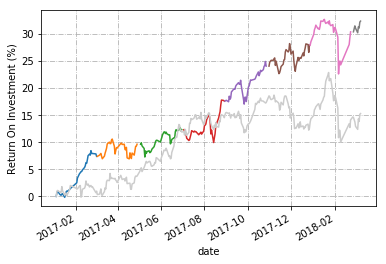

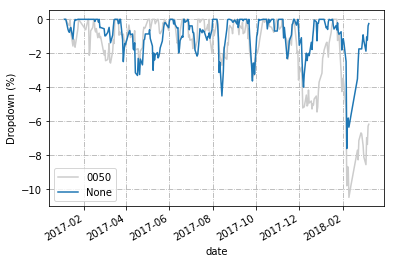

(2017-01-04    1.000000
 2017-01-05    1.006241
 2017-01-06    1.009988
 2017-01-09    1.004098
 2017-01-10    1.002802
 2017-01-11    1.002262
 2017-01-12    1.004416
 2017-01-13    1.005140
 2017-01-16    0.998278
 2017-01-17    1.003211
 2017-01-18    1.008285
 2017-01-19    1.009928
 2017-01-20    1.009556
 2017-01-23    1.012826
 2017-01-24    1.014618
 2017-02-02    1.025163
 2017-02-03    1.034065
 2017-02-06    1.042286
 2017-02-07    1.043727
 2017-02-08    1.045739
 2017-02-09    1.046101
 2017-02-10    1.048853
 2017-02-13    1.053477
 2017-02-14    1.056533
 2017-02-15    1.062483
 2017-02-16    1.061178
 2017-02-17    1.067931
 2017-02-18    1.075381
 2017-02-20    1.078084
 2017-02-21    1.076289
                 ...   
 2018-01-17    1.327210
 2018-01-18    1.322244
 2018-01-19    1.319612
 2018-01-22    1.322394
 2018-01-23    1.318934
 2018-01-24    1.324492
 2018-01-25    1.317191
 2018-01-26    1.315492
 2018-01-29    1.317514
 2018-01-30    1.303256
 2018-01-31    1

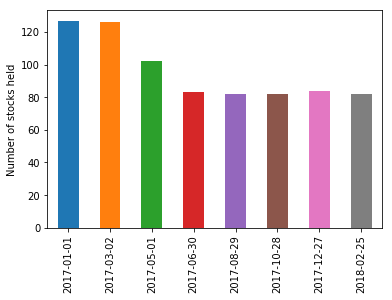

In [10]:
from finlab.backtest import backtest
from finlab.data import Data
import datetime

%matplotlib inline
data = Data()
backtest(datetime.date(2017,1,1), datetime.date(2018,3,10), 60, mystrategy, data)